In [420]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfilename
import csv
from pathlib import Path
import pymongo
import numpy as np
# Use sentinel for missing values
from numpy import nan as NA
import pandas as pd
# For showing plots in tkinter
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  
NavigationToolbar2Tk) 
import seaborn as sns

# connect to mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
# create db
db_formative = client["summative"]
# create collection
collection_vendors = db_formative["test-42"]

In [421]:
# Global variables
fileButtons = ["inspections", "inventory", "violations"]
fileRoutes = {fileButtons[0]:"", fileButtons[1]:"", fileButtons[2]:""}

In [422]:
class Parser(object):
    def __init__(self, collection, csvFile):
        self.collection = collection
        self.csvFile = csvFile
        self.inspectionsDF = None
        self.inventoryDF = None
        self.violationsDF = None
        
    def parseData(self):
        # Read CSV files and convert to Pandas DataFrames
        self.inspectionsDF = pd.read_csv(self.csvFile['inspections'])
        self.inventoryDF = pd.read_csv(self.csvFile['inventory'])
        self.violationsDF = pd.read_csv(self.csvFile['violations'])
        # Add '_id' for MongoDB      
        self.inspectionsDF['_id'] = 'INS_' + self.inspectionsDF['SERIAL NUMBER']
        
        # Insert into MongoDB
        self.insertToMongo()
        
        # Clean data
        cleaner = DataCleaner(self.inspectionsDF, self.violationsDF, self.collection)
        cleaner.clean()
        print(self.violationsDF)
        return self.violationsDF

        
    def insertToMongo(self):
        # use to_dict to format correctly for MongoDB
        inspectionsDict = self.inspectionsDF.to_dict(orient='records')
        inventoryDict = self.inventoryDF.to_dict(orient='records')
        violationsDict = self.violationsDF.to_dict(orient='records')
        # Insert into Mongo
        self.collection.insert_many(inspectionsDict)
        self.collection.insert_many(inventoryDict)
        self.collection.insert_many(violationsDict)
        # Test db
        test = collection_vendors.find({'_id':{'$regex':'INS_'}})
        for t in test:
            print(f'testing inspections: \n{t}')
            break
        print('inserted into Mongo')
                

In [423]:
class DataCleaner(object):
    def __init__(self, inspections, violations, collection):
        self.inspections = inspections
        self.violations = violations
        self.collection = collection
        
    def clean(self):
        print('cleaning')
        self.cleanInspections()
        self.cleanViolations()
        
    def cleanInspections(self):
        # find all inspections, split 'PE DESCRIPTION', insert new entries
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'}}, {'PE DESCRIPTION':1,'FACILITY ZIP':1 })
        for result in resultsInspections:
            # Extract seating details from 'PE DESCRIPTION'
            try:
                start,mid = result["PE DESCRIPTION"].split(' (')
                mid,end = mid.split(')')
                collection_vendors.update_one({'_id': result['_id']}, {'$set': {'PE DESCRIPTION': start+end}})
                collection_vendors.update_one({'_id': result['_id']}, {'$set': {'SEATING DETAILS': mid}})
            except:
                print('no seating desc')
            # Remove second half of zip (e.g. '90001-1234', becomes '90001')
            try:
                zipStart = result["FACILITY ZIP"].split('-')
                collection_vendors.update_one({'_id': result['_id']}, {'$set': {'FACILITY ZIP': zipStart[0]}})
            except:
                print('no zip')
        print('cleaned inspections')
        
    def cleanViolations(self):
        # Add violations as embedded docs to inspections
        print('start cleaning violations')
        # Find all inspections
        resultsViolations = collection_vendors.find({'VIOLATION DESCRIPTION':{'$regex':'#'}})
        for result in resultsViolations:
            collection_vendors.update_one({'_id':{'$regex':'INS_'},'SERIAL NUMBER': result['SERIAL NUMBER']}, {'$addToSet': {'VIOLATIONS': result}})
        print('finish cleaning violations')
        
            
        
        

In [424]:
class ButtonUpload(object):
    def __init__(self, fileButtons, fileLabels, counter, mainframe):
        self.fileButtons = fileButtons
        self.fileLabels = fileLabels
        self.counter = counter
        self.mainframe = mainframe
        self.filePath = ''
        self.uploadLabel = StringVar()

    def browseFile(self):
        self.filePath = askopenfilename(filetypes=[("CSV files", ".csv")])
        fileName = Path(self.filePath)
        self.uploadLabel.set(fileName.name)
        print(self.filePath)
        self.setFileRoutes()
    
    def setFileRoutes(self):
        fileRoutes[self.fileButtons] = self.filePath
        print(fileRoutes)
        
    def createButton(self):
        ttk.Label(self.mainframe, text=f"Upload data: {self.fileButtons}", anchor="w").grid(row=self.counter+1, column=0, sticky="w")
        Button(self.mainframe, text="Upload file", command=self.browseFile).grid(row=self.counter+1, column=1, sticky="w")
        ttk.Label(self.mainframe, textvariable=self.uploadLabel).grid(row=self.counter+1, column=2, sticky="w")  

In [425]:
class AveragesCalculator(object):
    def __init__(self, year, category):
        self.year = year
        self.category = category
        
    def zipScores(self):
        print(f'Calculating stats for: \n- Year = {self.year} \n- Category = {self.category}')
        # Find inspection documents - look in ispections (INS_) with year
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'},'ACTIVITY DATE':{'$regex':self.year}, 'PROGRAM STATUS': 'ACTIVE'})

        # Create dict of facility zips with lists of their scores
        zipScoresDict = {}  
        for r in resultsInspections:
            key = r[self.category]
            if key in zipScoresDict:
                zipScoresDict[r[self.category]].append(r['SCORE'])
            else:
                zipScoresDict[key] = [r['SCORE']]
        return self.calcZipStats(zipScoresDict)


    def calcZipStats(self, zipScoresDict):
        zipScoresMean = {}
        zipScoresMean = {self.category:[],'mean':[],'median':[],'mode':[]}
        for x in zipScoresDict:
            # Create Series to calc mean, mode, median
            tempSeries = pd.Series(zipScoresDict[x])
            mean = tempSeries.mean()
            mode = tempSeries.mode().tolist()
            median = tempSeries.median()

            # mean, mode, median as columns
            zipScoresMean[self.category].append(x)
            zipScoresMean['mean'].append(mean)
            zipScoresMean['median'].append(median)
            zipScoresMean['mode'].append(mode)

        # Create DataFrame
        zipScoresDF = pd.DataFrame(zipScoresMean)
        # sort by ascending cat - easier to find for user (esp. zip)
        zipScoresDF.sort_values(by=[self.category],inplace=True)
        # set cat as index
        zipScores_noIndex = zipScoresDF.set_index(self.category)
        
        return zipScores_noIndex
 

In [426]:
class UserInterface(object):
    def __init__(self, title):
        self.title = title
        self.mainframe = None
        self.window = Tk()
        self.window.title(self.title)
        self.window.geometry("600x400")
        self.window.columnconfigure(0, weight=1)
        self.window.rowconfigure(0, weight=1)
        self.calcCategory = StringVar()
        self.calcYear = StringVar()
        self.violationsDict = None
        self.dataDict = None
        self.violationsDF = None
        
    def createWindow(self):
        self.createInitialFrame()
        self.window.mainloop()
        
    def createInitialFrame(self):
         # variables
        labelTextOne = StringVar()
        labelTextTwo = StringVar()
        labelTextThree = StringVar()
        fileLabels = [labelTextOne, labelTextTwo, labelTextThree]
        # Config layout
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        self.mainframe.grid_rowconfigure(4, weight=1)
        self.mainframe.grid_columnconfigure(2, weight=1)
        heading = ttk.Label(self.mainframe, text="Load your dataset", anchor="w").grid(row=0, sticky="nw")
        # Create buttons for file uploads
        for i in range(0, len(fileButtons)): 
            newButton = ButtonUpload(fileButtons[i], fileLabels[i], i, self.mainframe)
            newButton.createButton()
        # Buttons for Cancel and Clean & Save
        footer = ttk.Frame(self.window, padding="16 0 0 0").grid(row=5, column=1)
        cancelButton = Button(self.mainframe, text="Cancel & exit", bg="red").grid(row=4, column=0, sticky="sw")
        saveButton = Button(self.mainframe, text="Save", command=self.handleSave).grid(row=4, column=2,sticky="se")
        
    def handleSave(self):
        self.loadingFrame('Your data is being parsed and loaded into MongoDB...')
        parser = Parser(collection_vendors, fileRoutes)
        self.violationsDF = parser.parseData()
        self.violationsDF
        print('done handleSave')
        self.createNotebook()
    
    def loadingFrame(self, text):
        self.mainframe.destroy()
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        heading = ttk.Label(self.mainframe, text="Please wait:", anchor="w").grid(row=0, sticky="nw")
        subheading = ttk.Label(self.mainframe, text=text, anchor="w").grid(row=1, sticky="nw")
        
    def createNotebook(self):
        print('Creating Notebook (Tabs)')
        self.mainframe.destroy()
        self.mainframe = ttk.Notebook(self.window)
        f1 = ttk.Frame(self.mainframe)  
        f2 = ttk.Frame(self.mainframe)  
        f3 = ttk.Frame(self.mainframe) 
        self.mainframe.add(f1, text='Averages')
        self.mainframe.add(f2, text='Violations per Establishment')
        self.mainframe.add(f3, text='Correlations')
        # ====== Widget for tab 1
        heading_one = ttk.Label(f1, text="Mean, Mode and Median", anchor="w").grid(row=0, sticky="nw")
        # Radio - Type
        radioHeadingOne = ttk.Label(f1, text="Calculate by seating type or zip codes:", anchor="w").grid(row=0, sticky="nw")
        Radiobutton(f1, text="Vendor seating type", padx = 20, variable=self.calcCategory, value='SEATING DETAILS').grid(row=1, column=0, sticky='w')
        Radiobutton(f1, text="Zip Code", padx = 20, variable=self.calcCategory, value='FACILITY ZIP').grid(row=2, column=0, sticky='w')
        # Radio - Years
        radioHeadingTwo = ttk.Label(f1, text="Select Year", anchor="w").grid(row=3, sticky="nw")
        yearsArr = ['2016', '2017', '2018', '2019']
        for i in range(len(yearsArr)):
            Radiobutton(f1, text=yearsArr[i], padx = 20, variable=self.calcYear, value=yearsArr[i]).grid(row=i+4, column=0, sticky='w')
        # Calc button
        calcButton = Button(f1, text="Calculate", command=self.calcAverages).grid(row=8, column=0, sticky="sw")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        
        # ====== Widget for tab 2
        heading_two = ttk.Label(f2, text="Violations per Establishment", anchor="w").grid(row=0, sticky="nw")
        self.createViolationsPlot(f2)
        
        # ====== Widget for tab 3
        heading_two = ttk.Label(f3, text="Correlation between the number of violations commited per vendor and their zip code", anchor="w").grid(row=0, sticky="nw")
        self.createCorrelationsPlot(f3)
        
    def createViolationsPlot(self, f2):
        # Create dict with violation codes as keys and no. of facilities that commited that violation as values
        vioDict = {}
        # Sort the violation codes for easier reading for user
        violationsList = self.violationsDF['VIOLATION CODE'].unique()
        sortedCodes = sorted(violationsList)
        for v in sortedCodes:
            resultsInspections = collection_vendors.find({'VIOLATIONS.VIOLATION CODE':v}, {'FACILITY NAME':1})
            # Hash map to see if facility has been included - only need ONE instance of violation per facility
            facilityNames = {}
            for r in resultsInspections:
                # if facility name has already been counted, continue to next loop
                if r['FACILITY NAME'] in facilityNames:
                    continue
                # else, facility name has not yet been counted, add appropriately
                else:
                    if v in vioDict:
                        vioDict[v] = vioDict[v] + 1
                    else:
                        vioDict[v] = 1

        
        # Display violations vs no. of establishments
        vioKeys = list(vioDict.keys())
        vioVals = list(vioDict.values())
        # Create 4 subplots using slices of the keys & values lists
        fig,a =  plt.subplots(2,2)
        a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
        a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
        a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
        a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
        # Show in console as well as window
        plt.show()

        # creating the Tkinter canvas containing the Matplotlib figure 
        canvas = FigureCanvasTkAgg(fig, master = f2)   
        canvas.draw() 

        # grid the canvas on the Tkinter window 
        canvas.get_tk_widget().grid(row=0) 
        
    def createCorrelationsPlot(self, f3):
        # Find number of violations per vendor, and their zip code
        insViosDict = {'Facility ID': [], 'Violations quant': [], 'Zip': []}
        insVios = collection_vendors.find({'_id':{'$regex':'INS_'}}, {'FACILITY ID':1,'VIOLATIONS':1, 'FACILITY ZIP':1})
        # Create arrays for each key in dictionary (use sentinel NA if value does not exist)
        for r in insVios:
            if 'FACILITY ID' in r:
                insViosDict['Facility ID'].append(r['FACILITY ID'])
            else:
                insViosDict['Facility ID'].append(NA)
            if 'VIOLATIONS' in r:
                insViosDict['Violations quant'].append(len(r['VIOLATIONS']))
            else:
                insViosDict['Violations quant'].append(NA)
            if 'FACILITY ZIP' in r:
                insViosDict['Zip'].append(r['FACILITY ZIP'])
            else:
                insViosDict['Zip'].append(NA)
                
        #  Create DataFrame - sorted by zip to make visualisations easier to understand
        insViosDF = pd.DataFrame(insViosDict)
        insViosDF.sort_values(by=['Zip'],inplace=True)

        # Creating the figure and Seaborn plot
        figure = Figure(figsize=(6, 6))
        ax = figure.subplots()
        sns.scatterplot(x="Zip", y="Violations quant", data=insViosDF, ax=ax)
        
        # create the Tkinter canvas 
        canvas = FigureCanvasTkAgg(figure, master = f3)   
        canvas.draw() 

        # placing the canvas on the Tkinter window 
        canvas.get_tk_widget().grid(row=1) 
    
    def calcAverages(self):
        calcCatVal = self.calcCategory.get()
        calcYearVal = self.calcYear.get()
        calcAv = AveragesCalculator(calcYearVal, calcCatVal)
        avResults = calcAv.zipScores()
        self.averagesResultsFrame(avResults, calcYearVal, calcCatVal)
        
    def averagesResultsFrame(self, resultsAv, calcYearVal, calcCatVal):
        avResultsWindow = Tk()
        avResultsWindow.title(f'Averages Results for {calcCatVal} in {calcYearVal}')
        avResultsWindow.geometry("600x400")
        avResultsWindow.columnconfigure(0, weight=1)
        avResultsWindow.rowconfigure(0, weight=1)
        mainframe = ttk.Frame(avResultsWindow, padding="16 16 16 16")
        mainframe.place(relheight=1, relwidth=1)

        tree = ttk.Treeview(mainframe)
        tree.place(relheight=1, relwidth=1)
        treescrolly = Scrollbar(mainframe, orient='vertical', command=tree.yview)
        treescrollx = Scrollbar(mainframe, orient='horizontal', command=tree.xview)
        tree.configure(xscrollcommand=treescrollx.set, yscrollcommand=treescrolly.set)
        treescrolly.pack(side='right', fill='y')
        treescrollx.pack(side='bottom', fill='x')

        tree["columns"]=("one","two","three")
        tree.column("#0", width=75, minwidth=75)
        tree.column("one", width=75, minwidth=75)
        tree.column("two", width=75, minwidth=75)
        tree.column("three", width=75, minwidth=75)

        tree.heading("#0",text="Seating")
        tree.heading("one", text="Mean")
        tree.heading("two", text="Median")
        tree.heading("three", text="Mode")

        for index, row in resultsAv.iterrows(): 
            tree.insert('','end', text=index, values=[row['mean'],row['median'],row['mode']])
        print(f'This is resultsAv: \n{resultsAv}')
 

/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_d

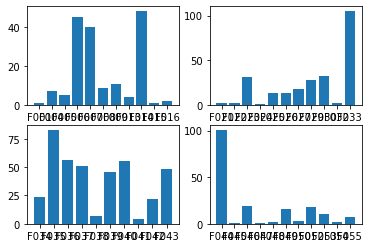

In [427]:
ui = UserInterface('summative')
ui.createWindow()

In [337]:
test = collection_vendors.find({'_id': {'$regex':'DA'}})
for t in test:
    print(t)

{'_id': 'INS_DA0004KIJ', 'ACTIVITY DATE': '02/07/2019', 'OWNER ID': 'OW0099597', 'OWNER NAME': 'ZARE INVESTMENTS INC', 'FACILITY ID': 'FA0067946', 'FACILITY NAME': 'ONE STOP SHOP MART', 'RECORD ID': 'PR0040362', 'PROGRAM NAME': 'ONE STOP SHOP MART', 'PROGRAM STATUS': 'ACTIVE', 'PROGRAM ELEMENT (PE)': 1610, 'PE DESCRIPTION': 'FOOD MKT RETAIL LOW RISK', 'FACILITY ADDRESS': '314 SANTA&#160;MONICA BLVD', 'FACILITY CITY': 'SANTA&#160;MONICA', 'FACILITY STATE': 'CA', 'FACILITY ZIP': '90401', 'SERVICE CODE': 1, 'SERVICE DESCRIPTION': 'ROUTINE INSPECTION', 'SCORE': 93.0, 'GRADE': 'A', 'SERIAL NUMBER': 'DA0004KIJ', 'EMPLOYEE ID': 'EE0001005', 'Location': 'POINT (-118.495685 34.015986)', '2011 Supervisorial District Boundaries (Official)': 3.0, 'Census Tracts 2010': 372.0, 'Board Approved Statistical Areas': 93.0, 'Zip Codes': 25426.0, 'SEATING DETAILS': '1-1,999 SF', 'VIOLATIONS': [{'_id': ObjectId('5fda6eab578ac57889f0dbfa'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANC

In [232]:
resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'},'ACTIVITY DATE':{'$regex':'2018'}})

# Create dict of facility zips with lists of their scores
zipScoresDict = {}  
for r in resultsInspections:
    key = r['SEATING DETAILS']
#             if(r['SCORE'] == NaN):
#                 value = NaN
#             else:
#                 value = int(r['SCORE'])
    if key in zipScoresDict:
        zipScoresDict[r['SEATING DETAILS']].append(value)
    else:
        zipScoresDict[key] = [value]

KeyError: 'SEATING DETAILS'

In [259]:
resultsInspections = collection_vendors.find({'_id':{'$regex': 'INS_'},'PROGRAM STATUS': 'ACTIVE'}, {'FACILITY NAME':1, 'VIOLATIONS':1})
    
for x in resultsInspections:
    print(x['VIOLATIONS'])
    

[{'_id': ObjectId('5fda6eab578ac57889f0dbfa'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F049', 'VIOLATION DESCRIPTION': '# 50. Impoundment of unsanitary equipment or food', 'POINTS': 0}, {'_id': ObjectId('5fda6eab578ac57889f0dbfb'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F042', 'VIOLATION DESCRIPTION': '# 42. Toilet facilities: properly constructed, supplied, cleaned', 'POINTS': 1}, {'_id': ObjectId('5fda6eab578ac57889f0dbfc'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F037', 'VIOLATION DESCRIPTION': '# 37. Adequate ventilation and lighting; designated areas, use', 'POINTS': 1}, {'_id': ObjectId('5fda6eab578ac57889f0dbfd'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F015', 'VIOLATION DESCRIPTION': '# 15. Food obtained from approved source', 'POINTS': 2}, {'_id': ObjectId('5fda6eab578ac57889

KeyError: 'VIOLATIONS'

In [275]:
vioDict = {
    'fd05': {
        'quantity': 34,
        'facilities': {
            'f1': 1,
            'f2': 1
        }
    },
    'fd06': {
        'quantity': 32,
        'facilities': {
            'f1': 1,
            'f2': 1
        }
    }
}

x = vioDict.values()
for i in vioDict:
    print(vioDict[i])

{'quantity': 34, 'facilities': {'f1': 1, 'f2': 1}}
{'quantity': 32, 'facilities': {'f1': 1, 'f2': 1}}


In [276]:
3 not in [2, 3, 4]

False

In [277]:
x = set()
x.add(3)
x.add(4)
x

{3, 4}

In [278]:
4 in x

True

In [280]:
5 not in x

True

In [321]:
resultsInspections = collection_vendors.find({'_id':{'$regex': 'INS_'},'PROGRAM STATUS': 'ACTIVE'}, {'FACILITY NAME':1, 'VIOLATIONS':1})
# Create dict to hold 'quantity' - number of facilities commited violation...
# and 'facilities' uses a set so entries can only be added once, and easily searched

# vioDict = {
#     'codes': {
#         'F043': 43,
#         'F044': 81
#     }
#     'facilities': {
#         'F043': {'fac1':1, 'fac2':1}
#     }
# }
vioDict = {'codes': {}, 'facilities': {}}
for result in resultsInspections:
    facility = result['FACILITY NAME']
    print(result['VIOLATIONS'])
    for violation in result['VIOLATIONS']:
        if violationCode in vioDict['codes'] and facility not in vioDict['facilities'][violationCode]:
            vioDict['codes'][violationCode] = vioDict['codes'][violationCode] + 1
        else:
            vioDict['codes'][violationCode] = 1
#             vioDict['facilities'][violationCode][facility] = 1
#         print('no violations')
vioDict

[{'_id': ObjectId('5fda6eab578ac57889f0dbfa'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F049', 'VIOLATION DESCRIPTION': '# 50. Impoundment of unsanitary equipment or food', 'POINTS': 0}, {'_id': ObjectId('5fda6eab578ac57889f0dbfb'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F042', 'VIOLATION DESCRIPTION': '# 42. Toilet facilities: properly constructed, supplied, cleaned', 'POINTS': 1}, {'_id': ObjectId('5fda6eab578ac57889f0dbfc'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F037', 'VIOLATION DESCRIPTION': '# 37. Adequate ventilation and lighting; designated areas, use', 'POINTS': 1}, {'_id': ObjectId('5fda6eab578ac57889f0dbfd'), 'SERIAL NUMBER': 'DA0004KIJ', 'VIOLATION  STATUS': 'OUT OF COMPLIANCE', 'VIOLATION CODE': 'F015', 'VIOLATION DESCRIPTION': '# 15. Food obtained from approved source', 'POINTS': 2}, {'_id': ObjectId('5fda6eab578ac57889

KeyError: 'F049'

In [320]:
vioDict

{'codes': {}, 'facilities': {}}

In [327]:
# Create an example dataframe
data = {'name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy', 'Amy'], 
        'year': [2012, 2012, 2013, 2014, 2014, 2014], 
        'reports': [4, 24, 31, 2, 3, 4]}
df = pd.DataFrame(data, index = ['Cochice', 'Pima', 'Santa Cruz', 'Maricopa', 'Yuma', 'tre'])
df


name  year  reports
Cochice     Jason  2012        4
Pima        Molly  2012       24
Santa Cruz   Tina  2013       31
Maricopa     Jake  2014        2
Yuma          Amy  2014        3
tre           Amy  2014        4

In [379]:
d = df['name'].unique()
list(d)

['Jason', 'Molly', 'Tina', 'Jake', 'Amy']